# 1. 보팅

## 실습: 위스콘신 유방암 데이터 활용

In [4]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split

In [10]:
# 데이터 불러오기
cancer = load_breast_cancer()

cancer.keys()

cancer_df = pd.DataFrame(cancer.data, columns = [cancer.feature_names])
cancer_df['target'] = cancer.target

print(cancer_df.shape)
cancer_df.head()

(569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [12]:
cancer_df['target'].value_counts()

(target,)
1            357
0            212
dtype: int64

#### 보팅 방식_소프트 

In [22]:
# 소프트 보팅 방식: 각 클래스의 확률의 평균으로 최종 예측 결과 냄
## 로지스틱회귀 + KNN 방식 

lr_clf = LogisticRegression(solver = 'liblinear')
kn_clf = KNeighborsClassifier(n_neighbors = 8)

# 보팅
vo_clf = VotingClassifier(estimators = [('LR', lr_clf), ("KNN", kn_clf)], voting = 'soft')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(cancer_df.iloc[:, :-1], cancer_df.iloc[:, -1],
                                                    test_size = 0.2,
                                                    random_state = 156)

# 학습
vo_clf.fit(X_train, y_train)

# 예측
pred = vo_clf.predict(X_test)

# 평가
print(f'{accuracy_score(y_test, pred):.4f}')

0.9561


#### 보팅 방식_하드

In [21]:
# 하드 보팅
# vo_clf = VotingClassifier(estimators = [('LR', lr_clf), ("KNN", kn_clf)], voting = 'soft')
vo_clf = VotingClassifier(estimators = [('LR', lr_clf), ("KNN", kn_clf)], voting = 'hard')

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(cancer_df.iloc[:, :-1], cancer_df.iloc[:, -1],
                                                    test_size = 0.2,
                                                    random_state = 156)

# 학습
vo_clf.fit(X_train, y_train)

# 예측
pred = vo_clf.predict(X_test)

# 평가
print(f'{accuracy_score(y_test, pred):.4f}')

0.9298


#### 단일 모델링_ 로지스틱 회귀

In [19]:
# 로지스틱 회귀로만

lr_clf = LogisticRegression(solver = 'liblinear')

lr_clf.fit(X_train, y_train)
pred_lr = lr_clf.predict(X_test)

print(f'{accuracy_score(y_test, pred_lr): .4f}')

 0.9474


#### 단일 모델링_knn

In [20]:
# KNN로만

kn_clf = KNeighborsClassifier(n_neighbors = 8)

kn_clf.fit(X_train, y_train)
pred_kn = kn_clf.predict(X_test)

print(f'{accuracy_score(y_test, pred_kn): .4f}')

 0.9386


#### 결론

- 보팅방식을 쓴다고해서 무조건 좋은 것은 아님. 개별로 학습시킨 모델이 더 성능이 좋을 수 있음
- 근데 대체적으로 하드보다 소프트 방식이 성능이 좋은 편

# 2. 배깅

## 랜덤 포레스트

## 실습: 사용자 행동 인식 데이터 활용

In [23]:
def get_human_dataset():
    # 컬럼명 생성
    feature_name_df = pd.read_csv('./필요데이터/human_activity/features.txt', 
                              sep = '\s+',
                              header = None,
                              names = ['columns_index', 'column_name'])
    feature_names = feature_name_df.iloc[:, 1].tolist()
    
    new_feature_names = []
    for i in range(len(feature_names)):
        cnt = feature_names[:i].count(feature_names[i])
        all_cnt = feature_names.count(feature_names[i])
        new_name = feature_names[i]
        if all_cnt > 1:
            new_name += '_' + str(cnt + 1)
        new_feature_names.append(new_name)

    # train, test 피처 데이터 불러오기
    X_train = pd.read_csv('./필요데이터/human_activity/train/X_train.txt', sep = '\s+', names = new_feature_names)
    X_test = pd.read_csv('./필요데이터/human_activity/test/X_test.txt', sep = '\s+', names = new_feature_names)
    
    # train, test 레이블 데이터 불러오기
    y_train = pd.read_csv('./필요데이터/human_activity/train/y_train.txt', sep = '\s+', names = ['action'])
    y_test = pd.read_csv('./필요데이터/human_activity/test/y_test.txt', sep = '\s+', names = ['action'])
    
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

#### 랜덤포레스트 모델링

In [27]:
# 랜덤포레스트 모델링
rf_clf = RandomForestClassifier(random_state = 0, 
                                max_depth = 8, 
                                min_samples_split = 16)

# 학습
rf_clf.fit(X_train, y_train)

# 예측
pred = rf_clf.predict(X_test)

# 평가
accuracy = accuracy_score(y_test, pred)
print(f'정확도: {accuracy: .4f}')

정확도:  0.9169


#### 결정트리 단일 모델링

In [30]:
dt_clf = DecisionTreeClassifier(max_depth = 8,
                                min_samples_split = 16)

dt_clf.fit(X_train, y_train)

pred_dt = dt_clf.predict(X_test)

accuracy_dt = accuracy_score(y_test, pred_dt)
print(f'정확도: {accuracy_dt: .4f}')

정확도:  0.8711


#### 결론
- 결론적으로는 랜덤포레스트 알고리즘을 활용한 것이 예측 성능이 좋게 나옴

### 하이퍼파라미터 튜닝_GridSearchCV

In [31]:
from sklearn.model_selection import GridSearchCV

In [42]:
params = {
    'max_depth': [8, 16, 24],
    'min_samples_leaf' : [1, 6, 12],
    'min_samples_split': [2, 8, 16, 20]
}

# 랜덤포레스트 모델링
rf_clf = RandomForestClassifier(n_estimators = 100,
                                random_state = 156,
                                n_jobs = -1)  # 컴퓨터의 모든 코어를 사용

# 하이퍼파라미터 찾기
grid_cv = GridSearchCV(rf_clf,
                       param_grid = params,
                       scoring = 'accuracy',
                       cv = 2,
                       n_jobs = -1)

grid_cv.fit(X_train, y_train)

print(f'최적의 파라미터: {grid_cv.best_params_}')
print(f'최적 파라미터의 최고 정확도: {grid_cv.best_score_}')

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  3.5min finished


최적의 파라미터: {'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 16}
최적 파라미터의 최고 정확도: 0.9164853101196953


In [43]:
# 하이퍼파라미터 활용 학습
best_rf_clf = grid_cv.best_estimator_

best_rf_clf.fit(X_train, y_train)

# 예측
pred = best_rf_clf.predict(X_test)

# 평가
accuracy = accuracy_score(y_test, pred)
print(f'정확도: {accuracy:.4f}')

정확도: 0.9111


In [44]:
rf_clf1 = RandomForestClassifier(n_estimators = 100,
                                random_state = 156,
                                max_depth = 8, 
                                min_samples_leaf = 6, 
                                min_samples_split = 16)

# 학습
rf_clf1.fit(X_train, y_train)

# 예측
pred = rf_clf1.predict(X_test)

# 평가
accuracy = accuracy_score(y_test, pred)
print(f'정확도: {accuracy:.4f}')

정확도: 0.9111


In [46]:
params = {
    'max_depth': [8, 16, 24],
    'min_samples_leaf' : [1, 6, 12],
    'min_samples_split': [2, 8, 16, 20]
}

# 랜덤포레스트 모델링
rf_clf = RandomForestClassifier(n_estimators = 100,
                                random_state = 0,
                                n_jobs = -1)  # 컴퓨터의 모든 코어를 사용

# 하이퍼파라미터 찾기
grid_cv = GridSearchCV(rf_clf,
                       param_grid = params,
                       scoring = 'accuracy',
                       cv = 2,
                       n_jobs = -1)

grid_cv.fit(X_train, y_train)

print(f'최적의 파라미터: {grid_cv.best_params_}')
print(f'최적 파라미터의 최고 정확도: {grid_cv.best_score_}')

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:  3.2min finished


최적의 파라미터: {'max_depth': 16, 'min_samples_leaf': 6, 'min_samples_split': 2}
최적 파라미터의 최고 정확도: 0.9164853101196953


In [47]:
# 하이퍼파라미터 활용 학습
best_rf_clf = grid_cv.best_estimator_

best_rf_clf.fit(X_train, y_train)

# 예측
pred = best_rf_clf.predict(X_test)

# 평가
accuracy = accuracy_score(y_test, pred)
print(f'정확도: {accuracy:.4f}')

정확도: 0.9260


In [60]:
rf_clf2 = RandomForestClassifier(n_estimators = 100,
                                 random_state = 0,
                                 max_depth = 16, 
                                 min_samples_leaf = 6, 
                                 min_samples_split = 2)

# 학습
rf_clf2.fit(X_train, y_train)

# 예측
pred = rf_clf2.predict(X_test)

# 평가
accuracy = accuracy_score(y_test, pred)
print(f'정확도: {accuracy:.4f}')

정확도: 0.9260


#### 결론
- random_state를 다르게 설정하니까 하이퍼파라미터 튜닝이 다르게 됨 (당연하겠지만 그래도 신기)
- 책에서는 best_estimators_ 안쓰고 따로 파라미터 지정 + random_state 똑같이 해서 돌렸는데 혹시나 다를까해서 best_estimators_써봤는데 역시 같음!

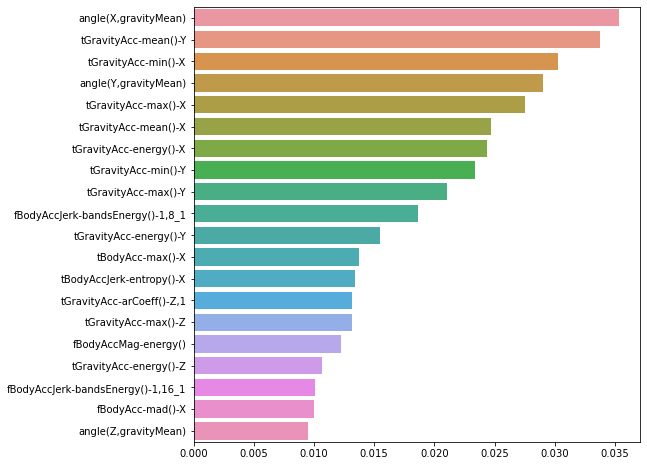

In [61]:
# 피처 중요도 시각화
import matplotlib.pyplot as plt
import seaborn as sns

top20_ft_import = pd.Series(best_rf_clf.feature_importances_, index = X_train.columns).sort_values(ascending = False)[:20]

plt.figure(figsize = (8,8))
sns.barplot(x = top20_ft_import, y = top20_ft_import.index)
plt.show()

# 3. 부스팅

## GBM(Gradient Boosting Machine)

- 가중치 업데이트 방식이 <b>경사하강법(실제값 - 예측값 차이를 최소화하는 방식)</b>임
- 회귀, 분류 모델링 둘 다 사용 가능

## 실습: 사용자 행동 인식 데이터 활용

In [62]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time
import warnings
warnings.filterwarnings('ignore')

In [63]:
# 데이터 불러오기
X_train, X_test, y_train, y_test =  get_human_dataset()

# GBM 걸리는 시간 측정
start_time = time.time()

# 모델링
gb_clf = GradientBoostingClassifier(random_state = 0)
# 학습
gb_clf.fit(X_train, y_train)

# 예측
pred = gb_clf.predict(X_test)

# 평가
gb_accuracy = accuracy_score(y_test, pred)

print(f'정확도: {gb_accuracy:.4f}')
print(f'걸린 시간: {start_time} - {time.time()}')

정확도: 0.9389
걸린 시간: 1673269461.5829184 - 1673270469.6836863


#### 결론
- 기본 하이퍼파라미터만으로도 93.9%로 랜덤포레스트보다 높은 예측 성능을 나타냄
- 그렇지 않은 경우도 있겠지만, 일반적으로 뛰어난 경우가 많음
- 하지만 수행 시간이 오래걸린다는 단점이 너무 큼

## XGBoost

In [65]:
import xgboost
print(xgboost.__version__)

1.6.2


### 실습: 위스콘신 유방암 데이터 활용

### 파이썬 래퍼 XGBoost

In [66]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [67]:
# 데이터 불러오기
dataset =  load_breast_cancer()

X = dataset.data
y = dataset.target

cancer_df = pd.DataFrame(X, columns = dataset.feature_names)
cancer_df['target'] = y

cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [69]:
cancer_df['target'].value_counts()

1    357
0    212
Name: target, dtype: int64

In [70]:
cancer_df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


In [74]:
# 데이터분할
## 학습용 vs 테스트용 -> 8:2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156)

## 학습용 -> 학습용 vs 검증용 -> 9:1
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 156)


print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [80]:
# 모델링 전 파라미터 설정
dtr = xgb.DMatrix(data = X_tr, label = y_tr)    # 학습
dval = xgb.DMatrix(data = X_val, label = y_val)    # 검증
dtest = xgb.DMatrix(data = X_test, label = y_test)    # 테스트

params = {'max_depth': 3,    # 트리 깊이
          'eta': 0.05,     # 학습률
          'objective': 'binary:logistic',  # 목적함수: 이진분류
          'eval_metric': 'logloss'}   # 검증용 데이터의 평가 성능 지표 

num_rounds = 400

eval_list = [(dval, 'eval')]  # 평가 데이터 셋 명기


# 모델링
xgb_clf = xgb.train(params = params,
                    dtrain = dtr,
                    evals = [(dtr, 'train'),(dval, 'eval')],
                    num_boost_round = num_rounds,
                    early_stopping_rounds = 50)

## 126번에서 더이상 좋아지지 않음 -> 176번까지 학습하다가 종료

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52930
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31892	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	train-logloss:0.26389	eval-logloss:0.39050
[18]	train-logloss:0.25210	eval-logloss:0.38254
[19]	train-logloss:0.24123	eval-logloss:0.37393
[20]	train-logloss:0.23076	eval-logloss:0.36789
[2

[170]	train-logloss:0.01312	eval-logloss:0.26133
[171]	train-logloss:0.01304	eval-logloss:0.26148
[172]	train-logloss:0.01297	eval-logloss:0.26157
[173]	train-logloss:0.01285	eval-logloss:0.26253
[174]	train-logloss:0.01278	eval-logloss:0.26229
[175]	train-logloss:0.01267	eval-logloss:0.26086
[176]	train-logloss:0.01258	eval-logloss:0.26103


In [82]:
# 예측
pred_probs = xgb_clf.predict(dtest)
print(pred_probs[:10])

pred = [1 if pred_proba > 0.5 else 0 for pred_proba in pred_probs]
print(pred[:10])

[0.8447872  0.00842587 0.6796298  0.08113331 0.9751338  0.9988939
 0.9983084  0.9980654  0.99637896 0.00138468]
[1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [83]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

In [90]:
# 평가

print(f'오차행렬: \n{confusion_matrix(y_test, pred)}')
print(f'정확도: {accuracy_score(y_test, pred): .4f}')
print(f'정밀도: {precision_score(y_test, pred): .4f}')
print(f'재현율: {recall_score(y_test, pred): .4f}')
print(f'f1_score: {f1_score(y_test, pred): .4f}')
print(f'AUC score: {roc_auc_score(y_test, pred_probs): .4f}')

오차행렬: 
[[34  3]
 [ 2 75]]
정확도:  0.9561
정밀도:  0.9615
재현율:  0.9740
f1_score:  0.9677
AUC score:  0.9937


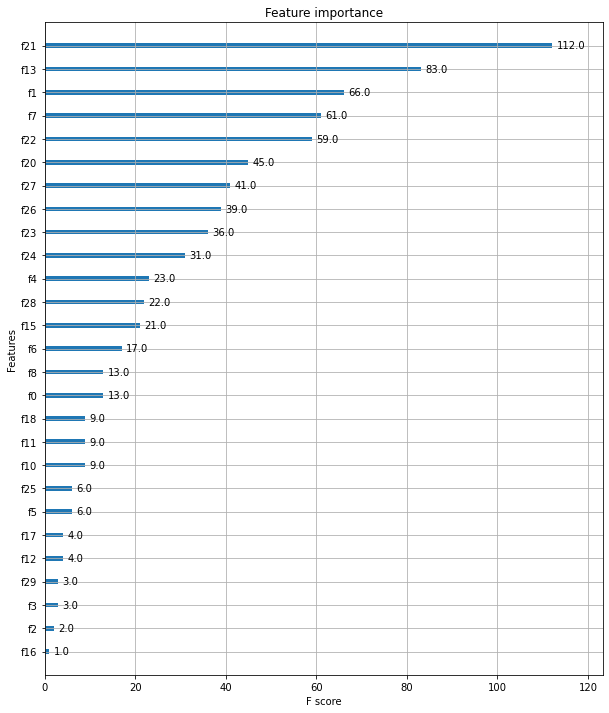

In [103]:
# 시각화
fig, ax = plt.subplots(figsize = (10,12))
plot_importance(xgb_clf, ax = ax)
plt.show()

#### 결론
- 정확도가 95.6%로 높음
- 속도도 엄청 빨랐음
- 일반적으로 사용했던 사이킷런 인자랑 달라서 좀 당황스럽긴 하다

### 사이킷런 래퍼 XGBoost

In [104]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

In [109]:
xgb_clf2 = XGBClassifier(n_estimators = 400,
                         learning_rate = 0.05,
                         max_depth = 3,
                         eval_metric = 'logloss')   # 이진분류가 default라 'objective': 'binary:logistic' 안써도됨

# 학습
xgb_clf2.fit(X_train, y_train,
             verbose = True)

# 예측
pred2 = xgb_clf2.predict(X_test)
pred_proba2 = xgb_clf2.predict_proba(X_test)[:,1]

print(pred2[:10])
print(np.round(pred_proba2[:10], 3))

[1 0 1 0 1 1 1 1 1 0]
[0.907 0.003 0.923 0.146 0.991 1.    1.    0.999 0.996 0.   ]


In [112]:
# 평가
print(f'오차 행렬: \n{confusion_matrix(y_test, pred2)}')
print(f'정확도: {accuracy_score(y_test, pred2):.4f}')
print(f'정밀도: {precision_score(y_test, pred2):.4f}')
print(f'재현율: {recall_score(y_test, pred2):.4f}')
print(f'f1 score: {f1_score(y_test, pred2):.4f}')
print(f'auc score: {roc_auc_score(y_test, pred_proba2):.4f}')

오차 행렬: 
[[34  3]
 [ 1 76]]
정확도: 0.9649
정밀도: 0.9620
재현율: 0.9870
f1 score: 0.9744
auc score: 0.9954


#### 결론
- 앞의 파이썬 XGBoost보다 좋게 나옴
- 이유:
    - 학습용데이터를 학습 + 검증용으로 나누지 않음
    - 조기 중단 안함

In [116]:
# 학습용 데이타 -> 학습 + 검증용 데이터로 나누기 + 조기중단(50번 )
evals = [(X_tr, y_tr), (X_val, y_val)]

# 학습
xgb_clf3 = XGBClassifier(n_estimators = 400,
                         max_depth = 3, 
                         learning_rate = 0.05)

xgb_clf3.fit(X_tr, y_tr, 
             eval_set = evals,
             early_stopping_rounds = 50,
             eval_metric = 'logloss',
             verbose = True)

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=400,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [117]:
# 예측
pred3 = xgb_clf3.predict(X_test)
pred_proba3 = xgb_clf3.predict_proba(X_test)[:,1]

print(pred3[:10])
print(np.round(pred_proba3[:10], 3))

[1 0 1 0 1 1 1 1 1 0]
[0.827 0.014 0.635 0.103 0.973 0.997 0.996 0.996 0.994 0.003]


In [118]:
# 평가
print(f'오차 행렬: \n{confusion_matrix(y_test, pred3)}')
print(f'정확도: {accuracy_score(y_test, pred3):.4f}')
print(f'정밀도: {precision_score(y_test, pred3):.4f}')
print(f'재현율: {recall_score(y_test, pred3):.4f}')
print(f'f1 score: {f1_score(y_test, pred3):.4f}')
print(f'auc score: {roc_auc_score(y_test, pred_proba3):.4f}')

오차 행렬: 
[[34  3]
 [ 2 75]]
정확도: 0.9561
정밀도: 0.9615
재현율: 0.9740
f1 score: 0.9677
auc score: 0.9933


#### 결론2
- 파이썬 래퍼 XGBoost랑 동일한 결과나옴(모든 파라미터를 똑같이 줬으니까 당연한 결과)

In [119]:
# 학습용 데이타 -> 학습 + 검증용 데이터로 나누기 + 조기중단(10번)
evals = [(X_tr, y_tr), (X_val, y_val)]

# 학습
xgb_clf4 = XGBClassifier(n_estimators = 400,
                         max_depth = 3, 
                         learning_rate = 0.05)

xgb_clf4.fit(X_tr, y_tr, 
             eval_set = evals,
             early_stopping_rounds = 10,
             eval_metric = 'logloss',
             verbose = True)

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52930
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31892	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=400,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [120]:
# 예측
pred4 = xgb_clf4.predict(X_test)
pred_proba4 = xgb_clf4.predict_proba(X_test)[:,1]

print(pred4[:10])
print(np.round(pred_proba4[:10], 3))

[1 0 1 0 1 1 1 1 1 0]
[0.811 0.019 0.65  0.141 0.967 0.991 0.991 0.99  0.99  0.008]


In [121]:
# 평가
print(f'오차 행렬: \n{confusion_matrix(y_test, pred4)}')
print(f'정확도: {accuracy_score(y_test, pred4):.4f}')
print(f'정밀도: {precision_score(y_test, pred4):.4f}')
print(f'재현율: {recall_score(y_test, pred4):.4f}')
print(f'f1 score: {f1_score(y_test, pred4):.4f}')
print(f'auc score: {roc_auc_score(y_test, pred_proba4):.4f}')

오차 행렬: 
[[34  3]
 [ 3 74]]
정확도: 0.9474
정밀도: 0.9610
재현율: 0.9610
f1 score: 0.9610
auc score: 0.9933


#### 결론3
- 조기중단 값을 확 줄이니까 정확도 떨어짐
- 적당한 조기중단값을 정하는 것도 예측 성능에 영향을 미친다~

## LGBM(Light Gradient Boosting Machine)

### 실습: 위스콘신 유방암 데이터 활용

In [122]:
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [123]:
# 데이터 불러오기
dataset = load_breast_cancer()

X = dataset.data
y = dataset.target

cancer_df = pd.DataFrame(X, columns = dataset.feature_names)
cancer_df['target'] = y

cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [124]:
# 데이터 분할

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 156)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                            test_size = 0.1,
                                            random_state = 156)


In [125]:
# 모델링
lgbm_clf = LGBMClassifier(n_estimators = 400,
                          learning_rate = 0.05)

evals = [(X_tr, y_tr), (X_val, y_val)]


# 학습
lgbm_clf.fit(X_tr, y_tr,
             early_stopping_rounds = 50,
             eval_set = evals,
             eval_metric = 'logloss',
             verbose = True)

[1]	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248
[2]	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	valid_1's binary_logloss: 0.502637
[8]	training's binary_logloss: 0.425055	valid_1's binary_logloss: 0.488311
[9]	training's binary_logloss: 0.405125	valid_1's binary_logloss: 0.474664
[10]	training's binary_logloss: 0.386526	valid_1's binary_logloss: 0.461267
[11]	training's binary_logloss: 0.367027	valid_1's binary_logloss: 0.444274
[12]	training's binary_logloss: 0.350713	valid_1's binary_logloss: 0.432755
[13]	training's binary_logloss: 0.334601	valid_1's binary_logloss: 0.421371
[14]	training's binary

LGBMClassifier(learning_rate=0.05, n_estimators=400)

In [126]:
# 예측
pred = lgbm_clf.predict(X_test)
pred_proba = lgbm_clf.predict_proba(X_test)[:, 1]

print(pred[:10])
print(pred_proba[:10])

[1 0 1 0 1 1 1 1 1 0]
[0.77697351 0.03051155 0.6908312  0.35348087 0.91411845 0.98203366
 0.98008954 0.97939707 0.98146778 0.02885693]


In [127]:
# 평가

print(f'오차행렬: \n{confusion_matrix(y_test, pred)}')
print(f'정확도: {accuracy_score(y_test, pred): .4f}')
print(f'정밀도: {precision_score(y_test, pred): .4f}')
print(f'재현율: {recall_score(y_test, pred): .4f}')
print(f'f1_score: {f1_score(y_test, pred): .4f}')
print(f'AUC score: {roc_auc_score(y_test, pred_proba): .4f}')

오차행렬: 
[[34  3]
 [ 2 75]]
정확도:  0.9561
정밀도:  0.9615
재현율:  0.9740
f1_score:  0.9677
AUC score:  0.9877


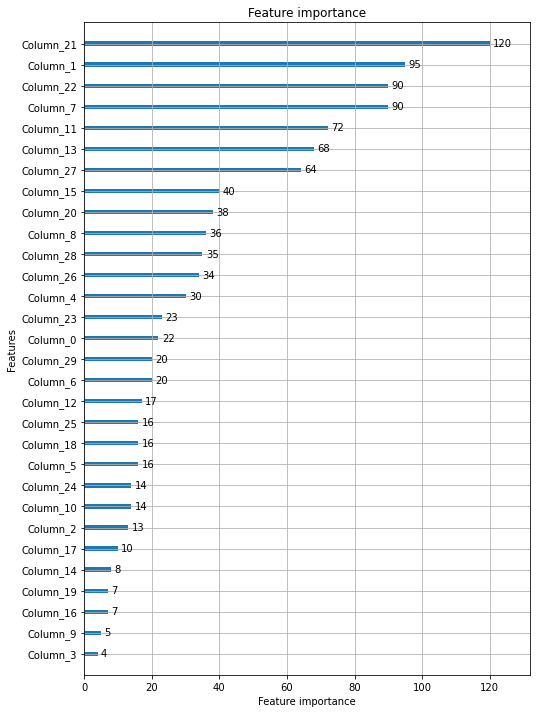

In [128]:
# 시각화
from lightgbm import plot_importance
import matplotlib.pylab as plt

fig, ax = plt.subplots(figsize = (8, 12))
plot_importance(lgbm_clf, ax = ax)
plt.show()

#### 결론
- XGBoost와 결과 차이가 크지 않고 걍 비슷함. auc는 오히려 조금 떨어짐
- 데이터 건수가 적기도 하고 하이퍼파라미터 튜닝을 안해봤기 때문일 듯

## 하이퍼파라미터 튜닝_베이지안 최적화

In [129]:
pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


In [130]:
# 데이터 분할

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 156)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                            test_size = 0.1,
                                            random_state = 156)

In [131]:
from hyperopt import hp

In [141]:
# max_depth는 5 ~ 20까지 1의 간격으로
# min_child_weight는 1 에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1 사이로
# learning_rate는 0.01에서 0.2까지 정규분포된 값으로 

xgb_search_space = {'max_depth': hp.quniform('max_depth', 5, 20, 1),
                    'min_child_weight': hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
                    }

In [142]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

In [146]:
# objective func 사용자함수 생성
## 실수형을 정수형으로 변환
## 최솟값을 최적화하는 부분을 최댓값으로 보완하기 위해 -1을 곱함

def objective_func(search_space):
    xgb_clf = XGBClassifier(n_estimators = 100,
                            max_depth = int(search_space['max_depth']),
                            min_child_weight = int(search_space['min_child_weight']),
                            learning_rate = search_space['learning_rate'],
                            colsample_bytree = search_space['colsample_bytree'],
                            eval_metric = 'logloss'
                           )
    
    accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring = 'accuracy', cv = 3)
    
    return {'loss': -1 * np.mean(accuracy), 'status': STATUS_OK}

In [147]:
from hyperopt import fmin, tpe, Trials

In [148]:
trial_val = Trials()
best = fmin(fn = objective_func,   # 목적 함수
            space = xgb_search_space,   # 하이퍼파라미터 검색 공간
            algo = tpe.suggest,    # 베이지안 최적화 알고리즘으로, default값임
            max_evals = 50,     # 최적 입력값을 찾기 위한 최대 반복횟수
            trials = trial_val,   # 최적 입력값을 찾기 위해 시도한 입력값 및 해당 입력값의 목적 함수 반환값 결과를 저장하는데 사용
            rstate = np.random.default_rng(seed = 9))  # 원래는 사용 안함(책과 동일한 결과를 위해서 사용)

print('best:', best)

100%|███████████████████████████████████████████████| 50/50 [00:35<00:00,  1.41trial/s, best loss: -0.9670616939700244]
best: {'colsample_bytree': 0.5424149213362504, 'learning_rate': 0.12601372924444681, 'max_depth': 17.0, 'min_child_weight': 2.0}


In [150]:
# 도출된 최적 파라미터들 적용

xgb_clf_result = XGBClassifier(n_estimators = 400,
                               max_depth = int(best['max_depth']),
                               learning_rate = best['learning_rate'],
                               min_child_weight = best['min_child_weight'],
                               colsample_bytree = best['colsample_bytree']
                               )

evals = [(X_tr, y_tr),(X_val, y_val)]

# 학습
xgb_clf_result.fit(X_tr, y_tr, 
                   eval_set = evals,
                   eval_metric = 'logloss',
                   early_stopping_rounds = 50,
                   verbose = True)

# 예측
pred = xgb_clf_result.predict(X_test)
pred_proba = xgb_clf_result.predict_proba(X_test)[:, 1]


# 평가
print(f'오차행렬: \n{confusion_matrix(y_test, pred)}')
print(f'정확도: {accuracy_score(y_test, pred): .4f}')
print(f'정밀도: {precision_score(y_test, pred): .4f}')
print(f'재현율: {recall_score(y_test, pred): .4f}')
print(f'f1_score: {f1_score(y_test, pred): .4f}')
print(f'AUC score: {roc_auc_score(y_test, pred_proba): .4f}')

[0]	validation_0-logloss:0.58942	validation_1-logloss:0.62047
[1]	validation_0-logloss:0.50801	validation_1-logloss:0.55913
[2]	validation_0-logloss:0.44160	validation_1-logloss:0.50928
[3]	validation_0-logloss:0.38734	validation_1-logloss:0.46815
[4]	validation_0-logloss:0.34223	validation_1-logloss:0.43913
[5]	validation_0-logloss:0.30424	validation_1-logloss:0.41570
[6]	validation_0-logloss:0.27178	validation_1-logloss:0.38952
[7]	validation_0-logloss:0.24502	validation_1-logloss:0.37317
[8]	validation_0-logloss:0.22049	validation_1-logloss:0.35628
[9]	validation_0-logloss:0.19872	validation_1-logloss:0.33797
[10]	validation_0-logloss:0.17945	validation_1-logloss:0.32462
[11]	validation_0-logloss:0.16353	validation_1-logloss:0.31384
[12]	validation_0-logloss:0.15031	validation_1-logloss:0.30607
[13]	validation_0-logloss:0.13812	validation_1-logloss:0.30143
[14]	validation_0-logloss:0.12798	validation_1-logloss:0.29512
[15]	validation_0-logloss:0.11925	validation_1-logloss:0.28890
[1

[130]	validation_0-logloss:0.01639	validation_1-logloss:0.22934
[131]	validation_0-logloss:0.01634	validation_1-logloss:0.22987
[132]	validation_0-logloss:0.01629	validation_1-logloss:0.22927
[133]	validation_0-logloss:0.01624	validation_1-logloss:0.23076
[134]	validation_0-logloss:0.01620	validation_1-logloss:0.23030
[135]	validation_0-logloss:0.01615	validation_1-logloss:0.22891
[136]	validation_0-logloss:0.01610	validation_1-logloss:0.22883
[137]	validation_0-logloss:0.01606	validation_1-logloss:0.22882
[138]	validation_0-logloss:0.01601	validation_1-logloss:0.22876
[139]	validation_0-logloss:0.01597	validation_1-logloss:0.22734
[140]	validation_0-logloss:0.01592	validation_1-logloss:0.22882
[141]	validation_0-logloss:0.01588	validation_1-logloss:0.22935
[142]	validation_0-logloss:0.01583	validation_1-logloss:0.22880
[143]	validation_0-logloss:0.01579	validation_1-logloss:0.22856
[144]	validation_0-logloss:0.01575	validation_1-logloss:0.22725
[145]	validation_0-logloss:0.01571	valid

#### 결론
- 하이퍼파라미터 튜닝하지 않은 결과보다 정확도가 높아짐
- 근데 유방암 데이터 자체가 워낙 건수도 적고, 학습, 검증, 테스트를 나누어서 튜닝을 한 것 자체가 그닥 큰 성능을 보이기 어려울 거같 고, 과적합이 될 수 있는 상황